# Comparison of BPC, GPC, and LQR on Linear Dynamical Systems

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
import numpy as onp
import jax.random as random
import tigercontrol
from tigercontrol.utils.random import set_key, generate_key
from tigercontrol.environments import Environment
from tigercontrol.controllers import Controller
from jax import grad,jit
import seaborn as sns; sns.set()
import pandas as pd

/Users/paulag/.local/lib/python3.6/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
from controllers.bpc import BPC
from controllers.gpc import GPC
from controllers.lqr import LQR

from environments.lds import LDS

alg_name = ['BPC', 'GPC', 'LQR']
color_code = {'BPC': 'orange', 'GPC': 'blue', 'LQR': 'green'}

In [3]:
# THIS SHOULD INCLUDE CONFIDENCE INTERVALS :(
# i.e. ci ='sd' should automatically do it!

def plot(title, data, scale = 'linear'):
    fig, axs = plt.subplots(ncols=2, figsize=(15,4))
    axs[0].set_yscale(scale)
    sns.lineplot(x = 'Time', y = 'Instantaneous Cost', hue = 'Algorithm', 
                 data = data, ax = axs[0], ci = 'sd', palette = color_code,
                err_style = 'band').set_title(title)
    axs[1].set_yscale(scale)
    sns.lineplot(x = 'Time', y = 'Average Cost', hue = 'Algorithm', 
                 data = data, ax = axs[1], ci = 'sd', palette = color_code).set_title(title)
    
def to_dataframe(alg, loss, avg_loss):
    global T
    return pd.DataFrame(data = {'Algorithm': alg, 'Time': np.arange(T, dtype=np.float32),
                                'Instantaneous Cost': loss, 'Average Cost': avg_loss})

In [4]:
n_runs = 5

In [5]:
def get_regret(T, model, x):
    loss = onp.zeros(T)
    avg_regret = onp.zeros(T)
    c_t = 0 # cost of initial function is 0
    for i in range(T):
        u = model.get_action()
        c_t = loss_fn(x, u)
        x = problem.step(u)
        model.update(c_t, x)
        loss[i] = c_t
        avg_regret[i] = avg_regret[-1] * i / (i+1) + c_t /(i+1)
    return loss, avg_regret

# Sanity Check

For the LDS system, the matrices A, B are generated randomly. The cost function used is c(x, u) = ||x||2 + ||u||2 . The baseline is designed with the pre-fixed matrix K set to 0. In all figures, we plot the averaged results for a fixed random system determined by A, B, for each setting, over 20 experiment runs.

In [6]:
noise_distribution = 'normal'

(a) d = 1

In [170]:
n = 1 # dimension of  the state x 
m = 1 # control dimension
T = 200 # number of timesteps

problem = LDS()

Q = 0.3 * np.identity(n)
R = 0.3 * np.identity(m)

loss_fn = lambda x, u: float(x.T @ Q @ x + u.T @ R @ u)

In [171]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
BPC_loss, BPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    loss_temp, avg_regret_temp = get_regret(T, bpc, x)
    BPC_loss, BPC_avg_regret = BPC_loss + (1/n_runs) * loss_temp, BPC_avg_regret + (1/n_runs) * avg_regret_temp

In [172]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()
GPC_loss, GPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    loss_temp, avg_regret_temp = get_regret(T, gpc, x)
    GPC_loss, GPC_avg_regret = GPC_loss + (1/n_runs) * loss_temp, GPC_avg_regret + (1/n_runs) * avg_regret_temp

In [173]:
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
lqr = LQR()
LQR_loss, LQR_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    loss_temp, avg_regret_temp = get_regret(T, lqr, x)
    LQR_loss, LQR_avg_regret = LQR_loss + (1/n_runs) * loss_temp, LQR_avg_regret + (1/n_runs) * avg_regret_temp

In [176]:
all_data = pd.concat([to_dataframe('BPC', BPC_loss, BPC_avg_regret), 
                      to_dataframe('GPC', GPC_loss, GPC_avg_regret),
                      to_dataframe('LQR', LQR_loss, LQR_avg_regret)])

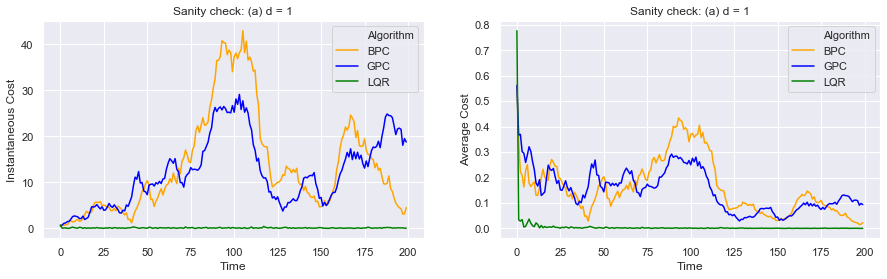

In [177]:
plot('Sanity check: (a) d = 1', all_data)

(b) d = 10

In [7]:
n = 10 # dimension of  the state x 
m = 10 # control dimension
T = 200 # number of timesteps

problem = LDS()

Q = 0.3 * np.identity(n)
R = 0.3 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [8]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
BPC_loss, BPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    loss_temp, avg_regret_temp = get_regret(T, bpc, x)
    BPC_loss, BPC_avg_regret = BPC_loss + (1/n_runs) * loss_temp, BPC_avg_regret + (1/n_runs) * avg_regret_temp

In [10]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()
GPC_loss, GPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    loss_temp, avg_regret_temp = get_regret(T, gpc, x)
    GPC_loss, GPC_avg_regret = GPC_loss + (1/n_runs) * loss_temp, GPC_avg_regret + (1/n_runs) * avg_regret_temp

In [11]:
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
lqr = LQR()
LQR_loss, LQR_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    loss_temp, avg_regret_temp = get_regret(T, lqr, x)
    LQR_loss, LQR_avg_regret = LQR_loss + (1/n_runs) * loss_temp, LQR_avg_regret + (1/n_runs) * avg_regret_temp

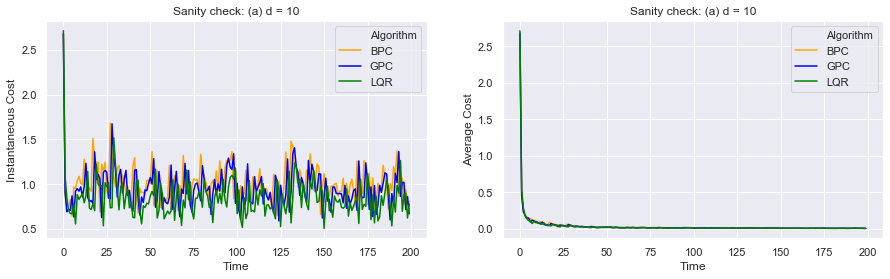

In [12]:
all_data = pd.concat([to_dataframe('BPC', BPC_loss, BPC_avg_regret), 
                      to_dataframe('GPC', GPC_loss, GPC_avg_regret),
                      to_dataframe('LQR', LQR_loss, LQR_avg_regret)])

plot('Sanity check: (b) d = 10', all_data)

(c) d = 100

In [37]:
n = 100 # dimension of  the state x 
m = 100 # control dimension
T = 500 # number of timesteps

problem = LDS()
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)

Q = 0.1 * np.identity(n)
R = 0.1 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [38]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
BPC_loss, BPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    loss_temp, avg_regret_temp = get_regret(T, bpc, x)
    BPC_loss, BPC_avg_regret = BPC_loss + (1/n_runs) * loss_temp, BPC_avg_regret + (1/n_runs) * avg_regret_temp

In [ ]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()
GPC_loss, GPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    loss_temp, avg_regret_temp = get_regret(T, gpc, x)
    GPC_loss, GPC_avg_regret = GPC_loss + (1/n_runs) * loss_temp, GPC_avg_regret + (1/n_runs) * avg_regret_temp

In [ ]:
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
lqr = LQR()
LQR_loss, LQR_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    loss_temp, avg_regret_temp = get_regret(T, lqr, x)
    LQR_loss, LQR_avg_regret = LQR_loss + (1/n_runs) * loss_temp, LQR_avg_regret + (1/n_runs) * avg_regret_temp

In [ ]:
all_data = pd.concat([to_dataframe('BPC', BPC_loss, BPC_avg_regret), 
                      to_dataframe('GPC', GPC_loss, GPC_avg_regret),
                      to_dataframe('LQR', LQR_loss, LQR_avg_regret)])

plot('Sanity check: (c) d = 100', all_data)

# Correlated noise experiment

## Gaussian Random Walk

In the first setting, the noise terms are $w_{t+1} ∼ N(w_t,0.3^2)$, and are then clipped to the range [−1, 1].

In [17]:
noise_magnitude = 0.1

In [18]:
def get_next_w(n, x, u, w, t):
    next_w = w + noise_magnitude * random.normal(generate_key(), shape = (n,))
    next_w = np.minimum(np.ones(n), next_w)
    next_w = np.maximum(-np.ones(n), next_w)
    return next_w

In [19]:
## PROBLEM ##
n = 10 # dimension of  the state x 
m = 10 # control dimension

problem = LDS()
x = problem.initialize(n, m, noise_distribution = get_next_w)

Q = 0.1 * np.identity(n)
R = 0.1 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [20]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
BPC_loss, BPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    loss_temp, avg_regret_temp = get_regret(T, bpc, x)
    BPC_loss, BPC_avg_regret = BPC_loss + (1/n_runs) * loss_temp, BPC_avg_regret + (1/n_runs) * avg_regret_temp

In [21]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()
GPC_loss, GPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    loss_temp, avg_regret_temp = get_regret(T, gpc, x)
    GPC_loss, GPC_avg_regret = GPC_loss + (1/n_runs) * loss_temp, GPC_avg_regret + (1/n_runs) * avg_regret_temp

In [22]:
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
lqr = LQR()
LQR_loss, LQR_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    loss_temp, avg_regret_temp = get_regret(T, lqr, x)
    LQR_loss, LQR_avg_regret = LQR_loss + (1/n_runs) * loss_temp, LQR_avg_regret + (1/n_runs) * avg_regret_temp

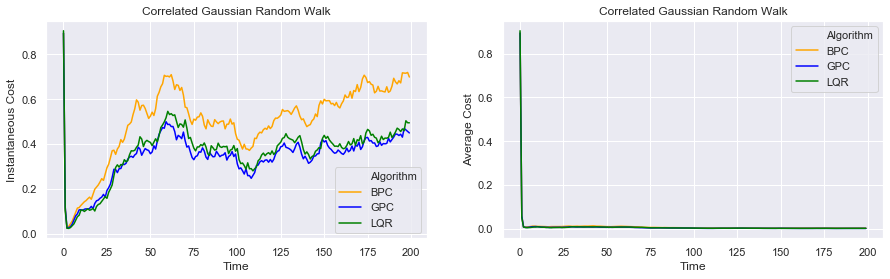

In [23]:
all_data = pd.concat([to_dataframe('BPC', BPC_loss, BPC_avg_regret), 
                      to_dataframe('GPC', GPC_loss, GPC_avg_regret),
                      to_dataframe('LQR', LQR_loss, LQR_avg_regret)])

plot('Correlated Gaussian Random Walk', all_data)

## Sine Noise

In [ ]:
noise_magnitude = 0.1

In [ ]:
def get_next_w(n, x, u, w, t):
    return noise_magnitude * np.sin(np.arange(t, t+n)/(2*n*np.pi))

In [ ]:
## PROBLEM ##
n = 10 # dimension of  the state x 
m = 10 # control dimension

problem = LDS()
x = problem.initialize(n, m, noise_distribution = get_next_w)

Q = 0.1 * np.identity(n)
R = 0.1 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [ ]:
K = np.zeros((m, n))
H = 8
delta = H **0.75 / T**0.25

bpc = BPC()
BPC_loss, BPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    bpc.initialize(problem.A, problem.B, n, m, H, K, delta, x)
    
    loss_temp, avg_regret_temp = get_regret(T, bpc, x)
    BPC_loss, BPC_avg_regret = BPC_loss + (1/n_runs) * loss_temp, BPC_avg_regret + (1/n_runs) * avg_regret_temp

In [ ]:
K = np.zeros((m, n))
H, HH = 8, 16

gpc = GPC()
GPC_loss, GPC_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    gpc.initialize(problem.A, problem.B, H, HH, K, x, loss_fn = loss_fn)
    
    loss_temp, avg_regret_temp = get_regret(T, gpc, x)
    GPC_loss, GPC_avg_regret = GPC_loss + (1/n_runs) * loss_temp, GPC_avg_regret + (1/n_runs) * avg_regret_temp

In [ ]:
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)
lqr = LQR()
LQR_loss, LQR_avg_regret = onp.zeros(T), onp.zeros(T)

for run in range(n_runs):
    set_key(run)
    
    x = problem.initialize(n, m, noise_distribution = get_next_w)
    lqr.initialize(problem.A, problem.B, n, m, x, Q, R)
    
    loss_temp, avg_regret_temp = get_regret(T, lqr, x)
    LQR_loss, LQR_avg_regret = LQR_loss + (1/n_runs) * loss_temp, LQR_avg_regret + (1/n_runs) * avg_regret_temp

In [ ]:
T = T - 10
all_data = pd.concat([to_dataframe('BPC', BPC_loss[10:], BPC_avg_regret[10:]), 
                      to_dataframe('GPC', GPC_loss[10:], GPC_avg_regret[10:]),
                      to_dataframe('LQR', LQR_loss[10:], LQR_avg_regret[10:])])

plot('Sinosoidal Noise', all_data)